DEBUG:poppy:Trans: None
DEBUG:poppy:OPD: wfe_on_axis.fits
DEBUG:poppy:No transmission supplied - will assume uniform throughput = 1 
INFO:poppy:OPD from wfe_on_axis.fits: Loaded OPD from wfe_on_axis.fits
INFO:poppy:No info supplied on amplitude transmission; assuming uniform throughput = 1
DEBUG:poppy:  Getting pixel scale from user-provided float value: 9.960937499999999e-06


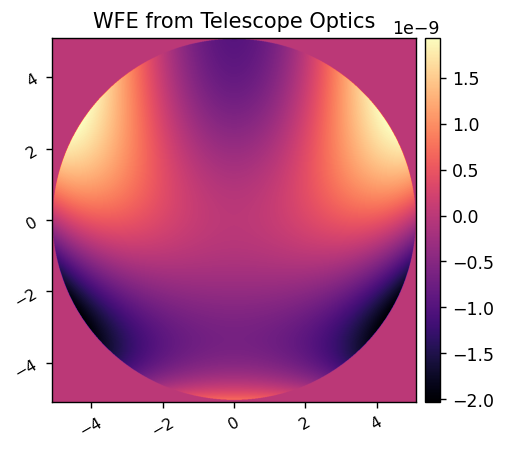

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, agpm
import misc_funs as misc
reload(full)

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

hdr = fits.getheader('wfe_on_axis.fits')
ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
                                   pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
misc.imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))

Propagating wavelength 750.000 nm.
PSF calculated in 0.306s


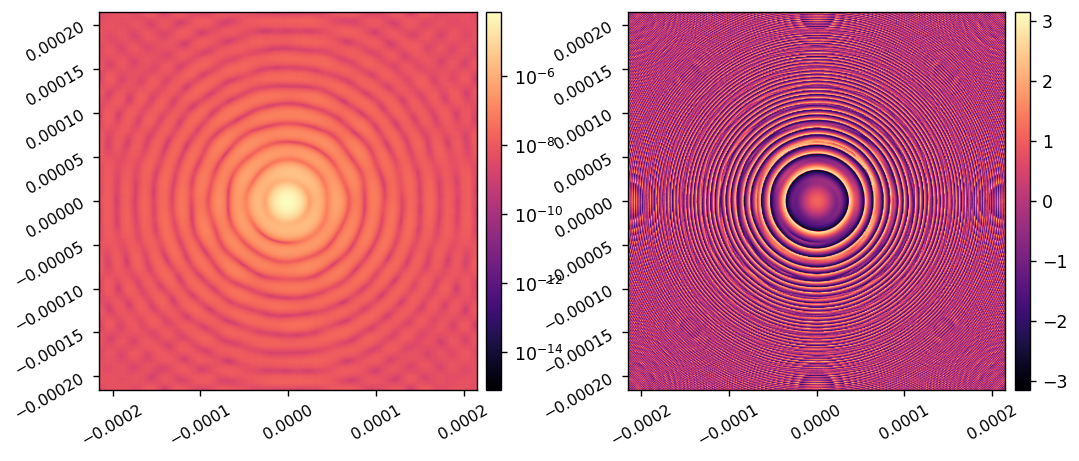

In [45]:
reload(full)
reload(misc)
poppy_log.disabled = True

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = full.CORO()

c.npix = 128
c.oversample = 16
c.npsf = 256
c.use_opds = True
c.OTEWFE = ote_wfe
c.defocus = 1000*wavelength_c

wf = c.calc_wfs()[-1]
psf = wf.wavefront
misc.imshow2(np.abs(psf)**2, np.angle(psf),
             pxscl=wf.pixelscale, 
             lognorm1=True)